# kAOV: Kernel Analysis Of Variance
## Tutorial: Model and Test Specification

In [1]:
import pandas as pd
from statsmodels.multivariate.manova import MANOVA as mnv_stats
from kaov import AOV
from patsy.contrasts import Sum, Diff

Various functionalities of the library will be demonstrated on a single-cell RT-qPCR dataset with a 4-level experimental condition of interest (i.e. Medium), and an 8-level batch effect. In this tutorial we will focus on different ways to specify the model and tests, and how this can be compared to classical coding schemes.

In [2]:
# Importing data:
url = "https://raw.githubusercontent.com/LMJL-Alea/kAOV/refs/heads/main/Data/reversion_kAOV.csv"
data = pd.read_csv(url, index_col=0)
# Specifying the formula for the dependent variables (genes):
form_exog = ' + '.join(data.columns[:-2])

An `AOV` instance can be directly created from the `exog` and `endog` matrices:

In [3]:
# Example with statsmodels' MANOVA:
fit = mnv_stats.from_formula(form_exog + ' ~ Medium + Batch', data=data)
res_0 = fit.mv_test()
print(res_0)

                   Multivariate linear model
                                                                
----------------------------------------------------------------
       Intercept         Value   Num DF  Den DF  F Value  Pr > F
----------------------------------------------------------------
          Wilks' lambda  0.0246 83.0000 592.0000 282.3807 0.0000
         Pillai's trace  0.9754 83.0000 592.0000 282.3807 0.0000
 Hotelling-Lawley trace 39.5905 83.0000 592.0000 282.3807 0.0000
    Roy's greatest root 39.5905 83.0000 592.0000 282.3807 0.0000
----------------------------------------------------------------
                                                                
----------------------------------------------------------------
         Medium         Value   Num DF    Den DF  F Value Pr > F
----------------------------------------------------------------
          Wilks' lambda 0.0362 249.0000 1776.3872 14.4452 0.0000
         Pillai's trace 1.8568 249.0000 1782.

In [5]:
## Init dirctly from endog and exog:
kfit_0 = AOV(fit.endog, fit.exog)
res_0 = kfit_0.test(hypotheses=None) 
print(res_0)

/Users/apollinaria45/Documents/Postdoc_Nantes_Venvs/ktest-main-venv/lib/python3.9/site-packages/kaov/kaov.py:630: UserWarning: If `hypotheses` is not specified, and `from_formula` interface not used to define the model, all `exog_names` are considered as levels of one factor.
  warnings.warn("If `hypotheses` is not specified, "


                  Kernel Analysis of Variance
                                                               
---------------------------------------------------------------
 Factor |  Trunc.   T=1      T=2      T=3      T=4       T=5   
---------------------------------------------------------------
        |    TKHL 293.6414 632.4118 840.0089 949.6627 1717.3707
        | P-value   0.0000   0.0000   0.0000   0.0000    0.0000



However, just like they do with `statsmodels`, we advise to use the `from_formula` interface. More particularly, we advise to use a specific coding scheme, adapted for all pre-defined hypothesis options. Let us start with a formal definition of the underlying model.

## Kernel AOV model
Let $\mathbf{Y} = (Y_1, \dots, Y_n)$ be a set of $n$ multivariate observations, such that $Y_i \in \mathbb{R}^d$ for $i \in \{1, \dots, n \}$. In the case of $N$ factors, for every $i$-th observation we define a factor variable of size $N$: $F_i = (l_i^1, \dots, l_i^N)$, where $l_i^f \in \{1, \dots, p_{f} \}$ for factor $f \in \{1, \dots, N \}$, with $p_{f}$ being the number of levels of the $f$-th factor. The kernel linear model can be defined as follows for the $k$-th observation:

\begin{equation}
    \phi(Y_{i}) = x_i^1 \theta_1 + \dots + x_i^{p} \theta_{p} + \epsilon_{i},
\end{equation}
where $\phi(Y_{i}) = k(Y_{i}, \cdot)$ is the embedding of $Y_{i}$ in $\mathcal{H}$, $\epsilon_{i} \in \mathcal{H}$ and $\theta_q \in \mathcal{H}$ for $q \in \{1, \dots, p\}$, with $p=\sum_{f=1}^N p_{f}$. We define the experimental design variable $x_i = (x_i^1, \dots, x_i^{p})$ such that for $q \in \{1, \dots, p\}$
\begin{equation}
  x_i^q = 
    \begin{cases}
      1 & \text{if } q \in \{l_i^1, p_{1}+l_i^2, \dots, p_{N-1}+l_i^N\}\\
      0 & \text{otherwise}.
    \end{cases}       
\end{equation}

The design matrix can then be denoted as $\mathbf{X}=(x_1, \dots, x_n)^\intercal \in \mathcal{M}_{n,p}(\mathbb{R})$. The model can be written in matrix form:
\begin{equation}
    \Phi(\mathbf{Y}) = \mathbf{X} \mathbf{\Theta} + \mathbf{E},
\end{equation}
with the design matrix $\mathbf{X}=(x_1, \dots, x_n)^\intercal \in \mathcal{M}_{n,p}(\mathbb{R})$, the vector of mean embeddings $\mathbf{\Theta}=(\theta_1, \dots, \theta_{p})^\intercal$ and $\mathbf{E}=(\epsilon_1, \dots, \epsilon_n)^\intercal$.


Such way of coding the design can be referred to as "one-hot encoding" in machine learning (in statistics also referred to as dummy coding, but we will not use this terminology here to avoid confusion with the dummy (treatment) coding scheme). The formula syntax is the same as with any contrast coding scheme defined in `statsmodels`. Here is an example with the previously used data, with both factors included:

In [7]:
# kAOV has a similar interface as statsmodels and uses a similar logic:
kfit_1 = AOV.from_formula(form_exog + ' ~ C(Medium, OneHot) + C(Batch, OneHot)', 
                          data=data)

In [8]:
# Design matrix:
kfit_1.exog

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.]], dtype=torch.float64)

In [9]:
kfit_1.exog[0]

tensor([1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=torch.float64)

## Different hypothesis tests
All hypothesis tests can be formalizes as follows:
$$
H_{0} : \mathbf{L} \mathbf{\Theta} = 0 \text{ and } H_{1} : \mathbf{L} \mathbf{\Theta} \neq 0,
$$
where $\mathbf{L}$ is a contrast matrix. For any $\mathbf{L}$, the kernel $T$-truncated Hotelling-Lawley (KTHL) test statistic is calculated:

\begin{equation}
\mathcal{F}_T = \operatorname{Tr}(\widehat{\Sigma}_T^{-} \widehat{H}_\mathbf{L}),
\end{equation}
where $ \widehat{H}_\mathbf{L}= (\mathbf{L}\widehat{\mathbf{\Theta}})^\star(\mathbf{L}(\mathbf{X}'\mathbf{X})^{-}\mathbf{L}')^{-1}(\mathbf{L}\widehat{\mathbf{\Theta}})$ is a Hilbert-Schmidt test operator associated with $\mathbf{L}$, and $\widehat{\Sigma}_T^{-}$ is the generalized inverse of the $T$-truncated residual covariance operator.

A hypothesis is formulated for each factor, or each level if `by_level=True`. To propose a general formulation for any factor, we introduce a factor-wise notation for the mean embeddings: $\mathbf{\Theta}=( \mathbf{\Theta}_1^\intercal, \dots, \mathbf{\Theta}_N^\intercal)^\intercal$, where $\mathbf{\Theta}_f = (\theta_{I_f+1}, \dots, \theta_{I_f+p_f})$, with $I_f=\sum_{f'=1}^{f-1} p_{f'}$ for $f \in \{1, \dots, N \}$.

### Hypothesis `'pairwise'`
#### Case `by_level=False`
For any factor $f \in \{1, \dots, N \}$, hypotheses of this type test for the equality of the effect of the levels of that factor:
\begin{equation}
    \begin{split}
        &H_{0} : \theta_{I_f+1}=\dots=\theta_{I_f+p_f} \\
        H_{1} : \exists (\theta, \theta') &\in (\theta_{I_f+1}, \dots, \theta_{I_f+p_f})^2 \text{ such that } \theta \neq \theta',
    \end{split}
\end{equation}

In [10]:
res_1_pw = kfit_1.test(hypotheses='pairwise')
print(res_1_pw)

                  Kernel Analysis of Variance
                                                               
---------------------------------------------------------------
 Medium |  Trunc.   T=1      T=2      T=3      T=4       T=5   
---------------------------------------------------------------
        |    TKHL 204.6946 423.7650 528.7334 552.0367 1263.0267
        | P-value   0.0000   0.0000   0.0000   0.0000    0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
    Batch |  Trunc.   T=1     T=2      T=3      T=4      T=5   
---------------------------------------------------------------
          |    TKHL 85.9009 209.6519 315.4264 401.4933 465.7612
          | P-value  0.0000   0.0000   0.0000   0.0000   0.0000



#### Case `by_level=True`
For a factor $f \in \{1, \dots, N \}$, a hypothesis is tested for each pair of factor levels $(q, q') \in \{1, \dots, p_f\}^2$, with a goal of comparing their effects:
$$
H_{0} : \theta_{I_f + q} = \theta_{I_f + q'} \text{ and } H_{1} : \theta_{I_f + q} \neq \theta_{I_f + q'}.
$$

In [11]:
res_1_pw_bl = kfit_1.test(hypotheses='pairwise', by_level=True)
print(res_1_pw_bl)

                              Kernel Analysis of Variance
                                                                                        
------------------------------------------------------------------------------------------
   Medium[0H] = Medium[24H] |  Trunc.     T=1       T=2       T=3        T=4        T=5   
------------------------------------------------------------------------------------------
                            |    TKHL   59.2494   71.8199   164.6241   171.1060   546.1395
                            | P-value    0.0000    0.0000     0.0000     0.0000     0.0000
----------------------------------------------------------------------------------------
                                                                                        
----------------------------------------------------------------------------------------
     Medium[0H] = Medium[48HDIFF] |  Trunc.   T=1      T=2      T=3      T=4      T=5   
------------------------------------------

### Hypothesis `'one-vs-all'`
#### Case `by_level=False`
For any factor $f \in \{1, \dots, N \}$, define the grand mean of the factor: $\mu_f=\tfrac{\theta_{I_f+1}+\dots+\theta_{I_f+p_f}}{p_f}$. Hypotheses of this type test for the equality of the effect of the levels of the factor with the grand mean:
\begin{equation}
    \begin{split}
        &H_{0} : \theta_{I_f+1}=\dots=\theta_{I_f+p_f}=\mu_f \\
        H_{1} : \exists \theta &\in \{\theta_{I_f+1}, \dots, \theta_{I_f+p_f}\} \text{ such that } \theta \neq \mu_f.
    \end{split}
\end{equation}

In [12]:
res_1_oa = kfit_1.test(hypotheses='one-vs-all')
print(res_1_oa)

                  Kernel Analysis of Variance
                                                               
---------------------------------------------------------------
 Medium |  Trunc.   T=1      T=2      T=3      T=4       T=5   
---------------------------------------------------------------
        |    TKHL 204.6946 423.7650 528.7334 552.0367 1263.0267
        | P-value   0.0000   0.0000   0.0000   0.0000    0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
    Batch |  Trunc.   T=1     T=2      T=3      T=4      T=5   
---------------------------------------------------------------
          |    TKHL 85.9009 209.6519 315.4264 401.4933 465.7612
          | P-value  0.0000   0.0000   0.0000   0.0000   0.0000



#### Case `by_level=True`
For a factor $f \in \{1, \dots, N \}$, a hypothesis is tested for each factor level $q \in \{1, \dots, p_f\}^2$, with a goal of comparing the individual effects to the grand mean:
$$
H_{0} : \theta_{I_f + q} = \mu_f \text{ and } H_{1} : \theta_{I_f + q} \neq \mu_f.
$$

In [13]:
res_1_oa_bl = kfit_1.test(hypotheses='one-vs-all', by_level=True)
print(res_1_oa_bl)

                                Kernel Analysis of Variance
                                                                                           
--------------------------------------------------------------------------------------------
   Medium[0H] = Medium Grand Mean |  Trunc.    T=1      T=2       T=3       T=4       T=5   
--------------------------------------------------------------------------------------------
                                  |    TKHL  63.5164  158.6202  245.7043  245.7928  668.9435
                                  | P-value   0.0000    0.0000    0.0000    0.0000    0.0000
-------------------------------------------------------------------------------------------
                                                                                           
--------------------------------------------------------------------------------------------
     Medium[24H] = Medium Grand Mean |  Trunc.    T=1      T=2      T=3      T=4      T=5   
-------------

# Comparison with classical coding schemes
In the case with just one factor, one-hot encoding combined with an appropriate contrast matrix $\mathbf{L}$ is actually equivalent to certain classical coding schemes. In order to obtain the classical coding scheme formulation, consider the following linear model:
\begin{equation}
    \Phi(\mathbf{Y}) = \mathbf{X_\gamma} \mathbf{\Gamma} + \mathbf{E},
\end{equation}
where $\mathbf{X_\gamma} \in \mathcal{M}_{n,p}(\mathbb{R})$ is a new design matrix and $\mathbf{\Gamma} \in \mathcal{H}^p$ is a new set of functional model parameters, describing the same data. We also define a new hypothesis, with a new contrast matrix $\mathbf{L_\gamma}$:
$$
H_{0}' : \mathbf{L_\gamma} \mathbf{\Gamma} = 0 \text{ and } H_{1}' : \mathbf{L_\gamma} \mathbf{\Gamma} \neq 0,
$$
which is equivalent to the previously defined one:
$$
H_{0} : \mathbf{L} \mathbf{\Theta} = 0 \text{ and } H_{1} : \mathbf{L} \mathbf{\Theta} \neq 0.
$$

The idea is to choose the model parametrization in such a way that allows to express the new contrast matrix as an identity matrix: $\mathbf{L_\gamma} = I_p$. Instead of encoding the contrasts in $\mathbf{L_\gamma}$, they are now encoded in the design matrix by setting $\mathbf{X_\gamma}=\mathbf{X}S$ for a certain matrix $S\in \mathcal{M}_{p}(\mathbb{R})$. Under these constraints, we have that

$$
\mathbf{X_\gamma} \mathbf{\Gamma} = \mathbf{X} \mathbf{\Theta} \iff \mathbf{X}S \mathbf{\Gamma}  = \mathbf{X} \mathbf{\Theta} \iff \mathbf{X}S\mathbf{L} \mathbf{\Theta}  = \mathbf{X} \mathbf{\Theta} \iff S = \mathbf{L}^{-1},
$$
given that $\mathbf{L}$ is invertable.

### Difference coding
Based on this reasoning, we can demonstrate the equivalence (in the one factor case) between the hypothesis tests proposed in our package combined with one-hot encoding, and different coding schemes combined with the identity contrast matrix (the default hypothesis scenario in our package as well as in `statsmodels`. First, define a one-factor model with one-hot encoding and extract the design matrix (i.e. $\mathbf{X}$):

In [14]:
# One factor case with OneHot:
kfit_1_1f = AOV.from_formula(form_exog + ' ~ C(Medium, OneHot)', data=data)
X = kfit_1_1f.exog
print(X)

tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]], dtype=torch.float64)


Consider first the `pairwise` hypothesis option. We perform the test and extract the contrast matrix (i.e. $\mathbf{L}$):

In [15]:
# set test_intercept=True to reproduce the intercept test of the Difference Coding scheme
res_1_1f_pw = kfit_1_1f.test(hypotheses='pairwise', test_intercept=True)
# concatenate both contrast matrices in one
L = np.concatenate([res_1_1f_pw.hypotheses[0][1], res_1_1f_pw.hypotheses[1][1]])
print(L)

[[ 0.25  0.25  0.25  0.25]
 [ 1.   -1.    0.    0.  ]
 [ 0.    1.   -1.    0.  ]
 [ 0.    0.    1.   -1.  ]]


Next, define a one-factor model with difference coding and extract the design matrix (i.e. $\mathbf{X_\gamma}$):

In [16]:
# Difference Coding:
kfit_diff = AOV.from_formula(form_exog + ' ~ C(Medium, Diff)', data=data)
kfit_diff.exog

tensor([[ 1.0000, -0.7500, -0.5000, -0.2500],
        [ 1.0000, -0.7500, -0.5000, -0.2500],
        [ 1.0000, -0.7500, -0.5000, -0.2500],
        ...,
        [ 1.0000,  0.2500,  0.5000,  0.7500],
        [ 1.0000,  0.2500,  0.5000,  0.7500],
        [ 1.0000,  0.2500,  0.5000,  0.7500]], dtype=torch.float64)

We can now check that $\mathbf{X_\gamma}=\mathbf{X}S$. Note: `patsy` (`statsmodel`'s dependency handling contrasts and many other things) has the backward difference option whereas `kmanova`'s `pairwise` option corresponds to the forward difference. They are essentially the same but in order to get the equivalence of designs we need to multiple the contarst matrix by -1 (without the intercept).

In [17]:
L_backward = L.copy()
L_backward[1:] *= -1
S = np.linalg.inv(L_backward)
# check the equality:
print((np.matmul(X, S) == kfit_diff.exog).all())

tensor(True)


We can also check that the tests produce the same result (set `hypotheses=None` to get the contrast matrix assigned to identity):

In [19]:
# Difference Coding:
res_diff = kfit_diff.test(hypotheses=None)
print(res_diff)

                      Kernel Analysis of Variance
                                                                       
-----------------------------------------------------------------------
    Intercept |  Trunc.   T=1     T=2       T=3       T=4       T=5    
-----------------------------------------------------------------------
              |    TKHL 11.9982 214.0758 1627.7281 8522.4231 11114.3568
              | P-value  0.0005   0.0000    0.0000    0.0000     0.0000
-----------------------------------------------------------------------
                                                                       
-----------------------------------------------------------------------
 C(Medium, Diff) |  Trunc.   T=1      T=2      T=3      T=4      T=5   
-----------------------------------------------------------------------
                 |    TKHL 124.6312 444.2971 514.1794 532.8491 969.9738
                 | P-value   0.0000   0.0000   0.0000   0.0000   0.0000



In [20]:
# One Hot Encoding:
print(res_1_1f_pw) # same result

                    Kernel Analysis of Variance
                                                                    
--------------------------------------------------------------------
 Intercept |  Trunc.   T=1     T=2       T=3       T=4       T=5    
--------------------------------------------------------------------
           |    TKHL 11.9982 214.0758 1627.7281 8522.4231 11114.3568
           | P-value  0.0005   0.0000    0.0000    0.0000     0.0000
--------------------------------------------------------------------
                                                                    
---------------------------------------------------------------------
   Medium |  Trunc.    T=1       T=2       T=3       T=4       T=5   
---------------------------------------------------------------------
          |    TKHL  124.6312  444.2971  514.1794  532.8491  969.9738
          | P-value    0.0000    0.0000    0.0000    0.0000    0.0000



With the `by_level` option we cover all possible comparisons between levels. Some to most of these combinations are covered by the by level versions of treatment and difference coding (i.e. testing the contrast matrices row by row).

In [22]:
# The most basic formula below produces treatment coding by default:
kfit_treat = AOV.from_formula(form_exog + ' ~ Medium', data=data)
res_treat = kfit_treat.test(hypotheses=None)
print(res_treat)

                   Kernel Analysis of Variance
                                                                  
------------------------------------------------------------------
 Intercept |  Trunc.   T=1     T=2      T=3       T=4       T=5   
------------------------------------------------------------------
           |    TKHL 44.0166 366.5924 972.8778 2594.8166 2749.2512
           | P-value  0.0000   0.0000   0.0000    0.0000    0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
     Medium |  Trunc.   T=1      T=2      T=3      T=4      T=5   
------------------------------------------------------------------
            |    TKHL 124.6312 444.2971 514.1794 532.8491 969.9738
            | P-value   0.0000   0.0000   0.0000   0.0000   0.0000



In [23]:
## By level:
res_treat_bl = kfit_treat.test(hypotheses=None, by_level=True)
print(res_treat_bl)

                      Kernel Analysis of Variance
                                                                        
-------------------------------------------------------------------------
   Intercept |  Trunc.    T=1      T=2       T=3        T=4        T=5   
-------------------------------------------------------------------------
             |    TKHL  44.0166  366.5924  972.8778  2594.8166  2749.2512
             | P-value   0.0000    0.0000    0.0000     0.0000     0.0000
------------------------------------------------------------------------
                                                                        
-------------------------------------------------------------------------
  Medium[T.24H] |  Trunc.    T=1      T=2      T=3       T=4       T=5   
-------------------------------------------------------------------------
                |    TKHL  39.0637  85.2228  149.0290  161.7483  402.4641
                | P-value   0.0000   0.0000    0.0000    0.0000  

In [24]:
# Difference Coding:
res_diff_bl = kfit_diff.test(hypotheses=None, by_level=True)
print(res_diff_bl)

                           Kernel Analysis of Variance
                                                                                 
-----------------------------------------------------------------------------------
      Intercept |  Trunc.     T=1       T=2         T=3         T=4         T=5    
-----------------------------------------------------------------------------------
                |    TKHL   11.9982   214.0758   1627.7281   8522.4231   11114.3568
                | P-value    0.0005     0.0000      0.0000      0.0000       0.0000
---------------------------------------------------------------------------------
                                                                                 
----------------------------------------------------------------------------------
   C(Medium, Diff)[D.0H] |  Trunc.    T=1      T=2      T=3       T=4       T=5   
----------------------------------------------------------------------------------
                         |    

In [25]:
# One Hot Coding:
res_1_1f_pw_bl = kfit_1_1f.test(hypotheses='pairwise', by_level=True)
print(res_1_1f_pw_bl) # same result (here one extra combination with OneHot)

                              Kernel Analysis of Variance
                                                                                       
----------------------------------------------------------------------------------------
      Medium[0H] = Medium[24H] |  Trunc.    T=1      T=2      T=3       T=4       T=5   
----------------------------------------------------------------------------------------
                               |    TKHL  39.0637  85.2228  149.0290  161.7483  402.4641
                               | P-value   0.0000   0.0000    0.0000    0.0000    0.0000
---------------------------------------------------------------------------------------
                                                                                       
---------------------------------------------------------------------------------------
     Medium[0H] = Medium[48HDIFF] |  Trunc.   T=1     T=2      T=3      T=4      T=5   
---------------------------------------------------------

### Sum (Deviation) coding
Similarly, it can be shown that the `one-vs-all` hypothesis option is equivalent to sum coding. Let us check that $\mathbf{X_\gamma}=\mathbf{X}S$:

In [26]:
# One Hot Coding:
res_1_1f_oa = kfit_1_1f.test(hypotheses='one-vs-all', test_intercept=True)
# concatenate both contrast matrices in one
L = np.concatenate([res_1_1f_oa.hypotheses[0][1], res_1_1f_oa.hypotheses[1][1]])
print(L)

[[ 0.25  0.25  0.25  0.25]
 [ 0.75 -0.25 -0.25 -0.25]
 [-0.25  0.75 -0.25 -0.25]
 [-0.25 -0.25  0.75 -0.25]]


In [27]:
# Sum Coding:
kfit_sum = AOV.from_formula(form_exog + ' ~ C(Medium, Sum)', data=data)
S = np.linalg.inv(L)
# check the equality:
print((np.matmul(X, S) == kfit_sum.exog).all())

tensor(True)


Check that the tests produce the same result:

In [29]:
# Sum Coding:
res_sum = kfit_sum.test(hypotheses=None)
print(res_sum)

                     Kernel Analysis of Variance
                                                                      
----------------------------------------------------------------------
   Intercept |  Trunc.   T=1     T=2       T=3       T=4       T=5    
----------------------------------------------------------------------
             |    TKHL 11.9982 214.0758 1627.7281 8522.4231 11114.3568
             | P-value  0.0005   0.0000    0.0000    0.0000     0.0000
----------------------------------------------------------------------
                                                                      
----------------------------------------------------------------------
 C(Medium, Sum) |  Trunc.   T=1      T=2      T=3      T=4      T=5   
----------------------------------------------------------------------
                |    TKHL 124.6312 444.2971 514.1794 532.8491 969.9738
                | P-value   0.0000   0.0000   0.0000   0.0000   0.0000



In [30]:
# One Hot Coding:
print(res_1_1f_oa) # same result (global tests are actually all the same)

                    Kernel Analysis of Variance
                                                                    
--------------------------------------------------------------------
 Intercept |  Trunc.   T=1     T=2       T=3       T=4       T=5    
--------------------------------------------------------------------
           |    TKHL 11.9982 214.0758 1627.7281 8522.4231 11114.3568
           | P-value  0.0005   0.0000    0.0000    0.0000     0.0000
--------------------------------------------------------------------
                                                                    
---------------------------------------------------------------------
   Medium |  Trunc.    T=1       T=2       T=3       T=4       T=5   
---------------------------------------------------------------------
          |    TKHL  124.6312  444.2971  514.1794  532.8491  969.9738
          | P-value    0.0000    0.0000    0.0000    0.0000    0.0000



The `by_level` option compares every level of each factor to the grand mean of the factor. We can chack that the results with one-hot encoding and with sum coding are the same:

In [31]:
## By level:
# Sum Coding:
res_sum_bl = kfit_sum.test(hypotheses=None, by_level=True)
print(res_sum_bl)

                          Kernel Analysis of Variance
                                                                                
----------------------------------------------------------------------------------
     Intercept |  Trunc.     T=1       T=2         T=3         T=4         T=5    
----------------------------------------------------------------------------------
               |    TKHL   11.9982   214.0758   1627.7281   8522.4231   11114.3568
               | P-value    0.0005     0.0000      0.0000      0.0000       0.0000
--------------------------------------------------------------------------------
                                                                                
---------------------------------------------------------------------------------
  C(Medium, Sum)[S.0H] |  Trunc.    T=1      T=2       T=3       T=4       T=5   
---------------------------------------------------------------------------------
                       |    TKHL  31.8201 

In [32]:
# One Hot Coding:
res_1_1f_oa_bl = kfit_1_1f.test(hypotheses='one-vs-all', by_level=True)
print(res_1_1f_oa_bl) # same result

                               Kernel Analysis of Variance
                                                                                          
-------------------------------------------------------------------------------------------
  Medium[0H] = Medium Grand Mean |  Trunc.    T=1      T=2       T=3       T=4       T=5   
-------------------------------------------------------------------------------------------
                                 |    TKHL  31.8201  187.2630  230.8348  233.6611  463.7776
                                 | P-value   0.0000    0.0000    0.0000    0.0000    0.0000
------------------------------------------------------------------------------------------
                                                                                          
-------------------------------------------------------------------------------------------
    Medium[24H] = Medium Grand Mean |  Trunc.    T=1      T=2      T=3      T=4      T=5   
------------------------

## Vizualization tools
### Diagnostic plots
As a first visualization of the data embedded in the RKHS, we propose the so-called "diagnostic plots". These are plots of the projections of the residuals onto the eigenfuction of the residual covariance operator, plotted against the projections of the predictions onto these eigenfuction.

Example for two factors:

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Batch'}>,
        <Axes: title={'center': 'Medium'}>], dtype=object))

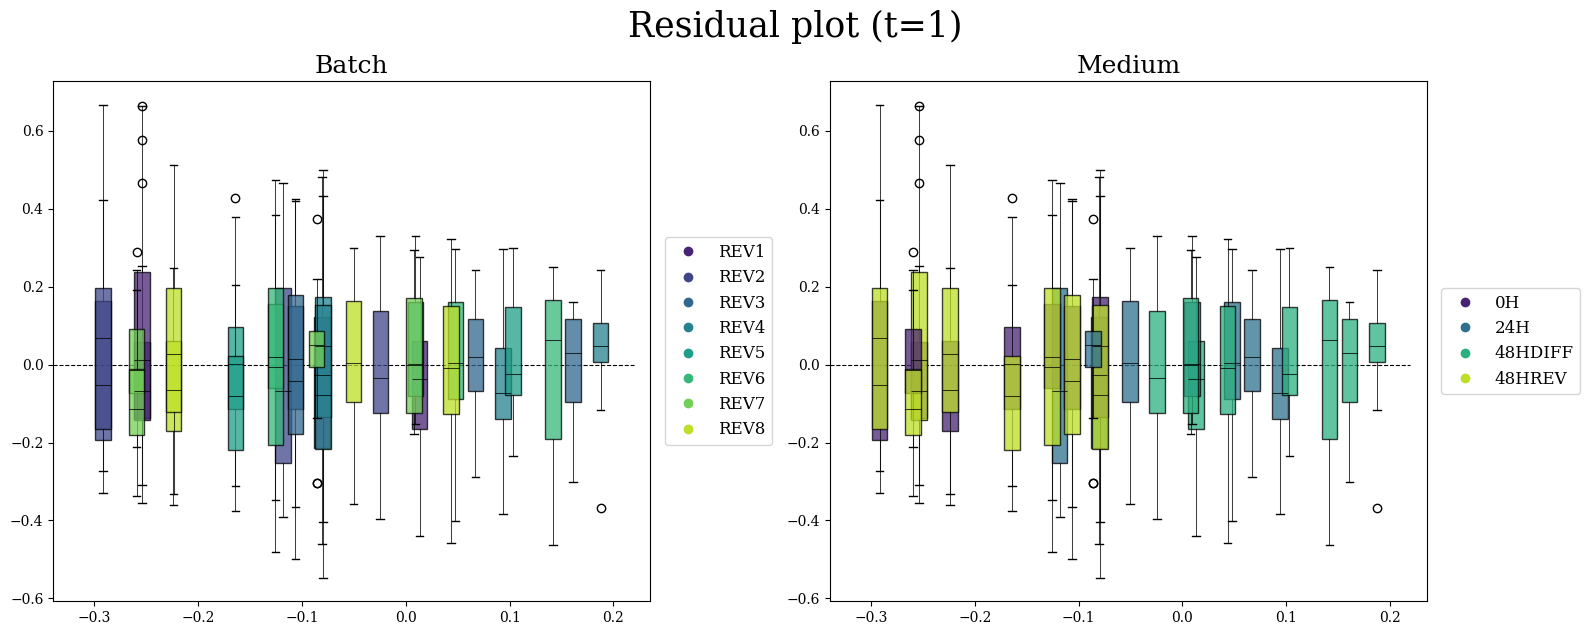

In [34]:
kfit_1.plot_diagnostics(t=1)

### Projections
We propose a vizualization of densities the embeddings' projections of onto the so-called discriminant directions: directions in the feature space, discriminating different levels of a factor, with respect to the chosen hypothesis. They can be represented by the eigenfunctions of $\Sigma_T^{-} \widehat{H}_\mathbf{L}$. Thus the quantity of interest is the vector of projections of the embeddings onto a unit eigenfunction $\widehat{g} \in \mathcal{H}$ of $\Sigma_T^{-} \widehat{H}_\mathbf{L}$, associated with the the eigenvalue $\widehat{\lambda}$, which can be written as follows:
$$
    \operatorname{Proj}_{\mathbf{L}, T}=\left(\langle \widehat{g} ,  \phi(Y_{i})  \rangle_{\mathcal{H}}\right)_{i \in \{1, \dots, n \}} ,
$$
where $\mathit{v} \in \mathbb{R}^T$ is a unit eigenvector  of $\mathbf{K}_T \mathbf{D} \mathbf{K}_T'$, associated with $\widehat{\lambda}$.

Example for the pairwise global test:


(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Medium'}>,
        <Axes: title={'center': 'Batch'}>], dtype=object))

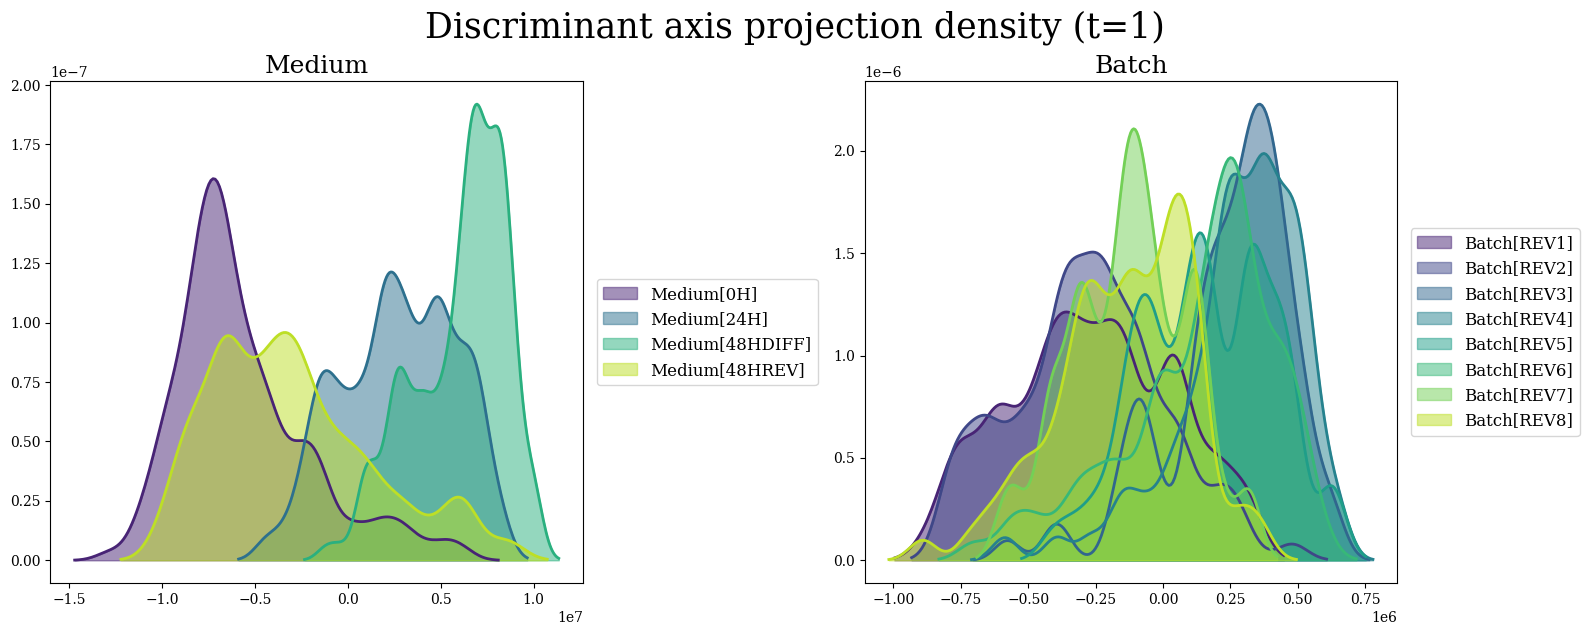

In [35]:
res_1_pw.plot_density(t=1)

In the by-level case, only the observations corresponding to relevant factor levels are shown on each subplot. There is also an option of selecting hypotheses to plot with argument `tests`:

(<Figure size 4800x600 with 6 Axes>,
 array([<Axes: title={'center': 'Medium[0H] = Medium[24H]'}>,
        <Axes: title={'center': 'Medium[0H] = Medium[48HDIFF]'}>,
        <Axes: title={'center': 'Medium[0H] = Medium[48HREV]'}>,
        <Axes: title={'center': 'Medium[24H] = Medium[48HDIFF]'}>,
        <Axes: title={'center': 'Medium[24H] = Medium[48HREV]'}>,
        <Axes: title={'center': 'Medium[48HDIFF] = Medium[48HREV]'}>],
       dtype=object))

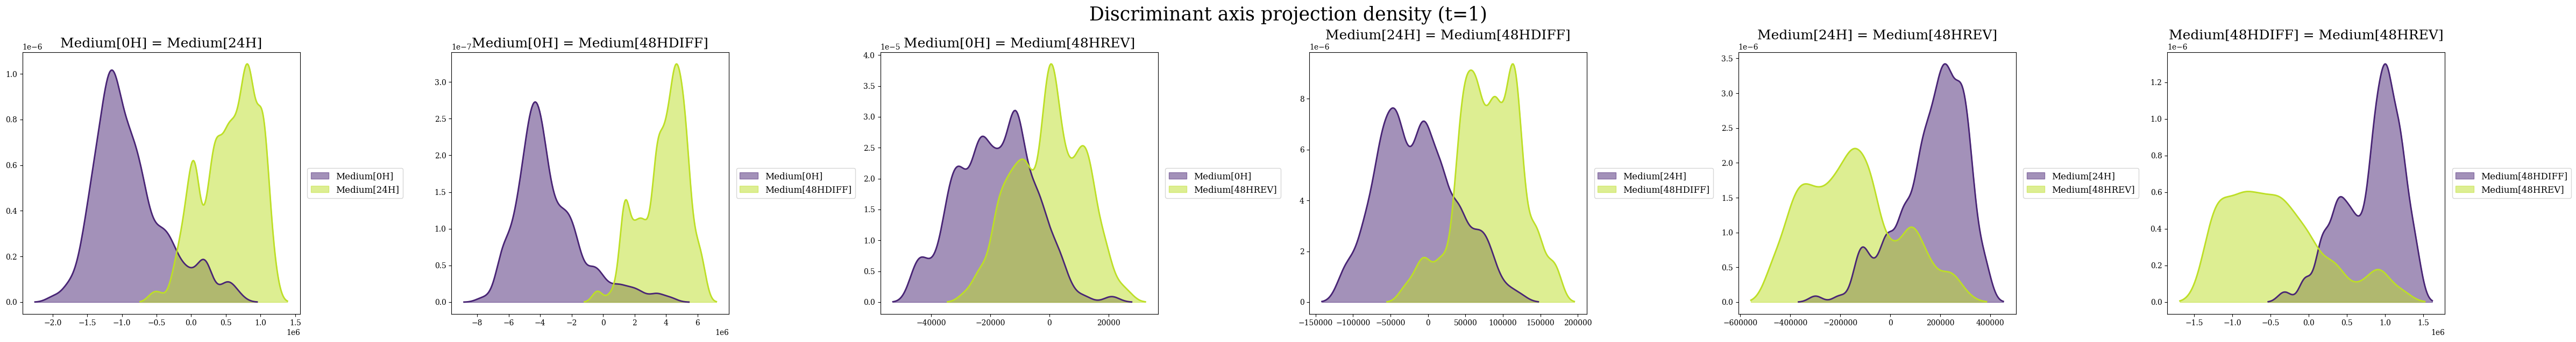

In [37]:
res_1_pw_bl.plot_density(t=1, tests=[n for n, _ in res_1_pw_bl.hypotheses[:6]])

### Influence plot
The influence plots are represented by scatter plots of the Cook's distances for each observation, plotted against their projections on the discriminant axis.

Example for the pairwise global test:

(<Figure size 1600x600 with 2 Axes>,
 array([<Axes: title={'center': 'Medium'}>,
        <Axes: title={'center': 'Batch'}>], dtype=object))

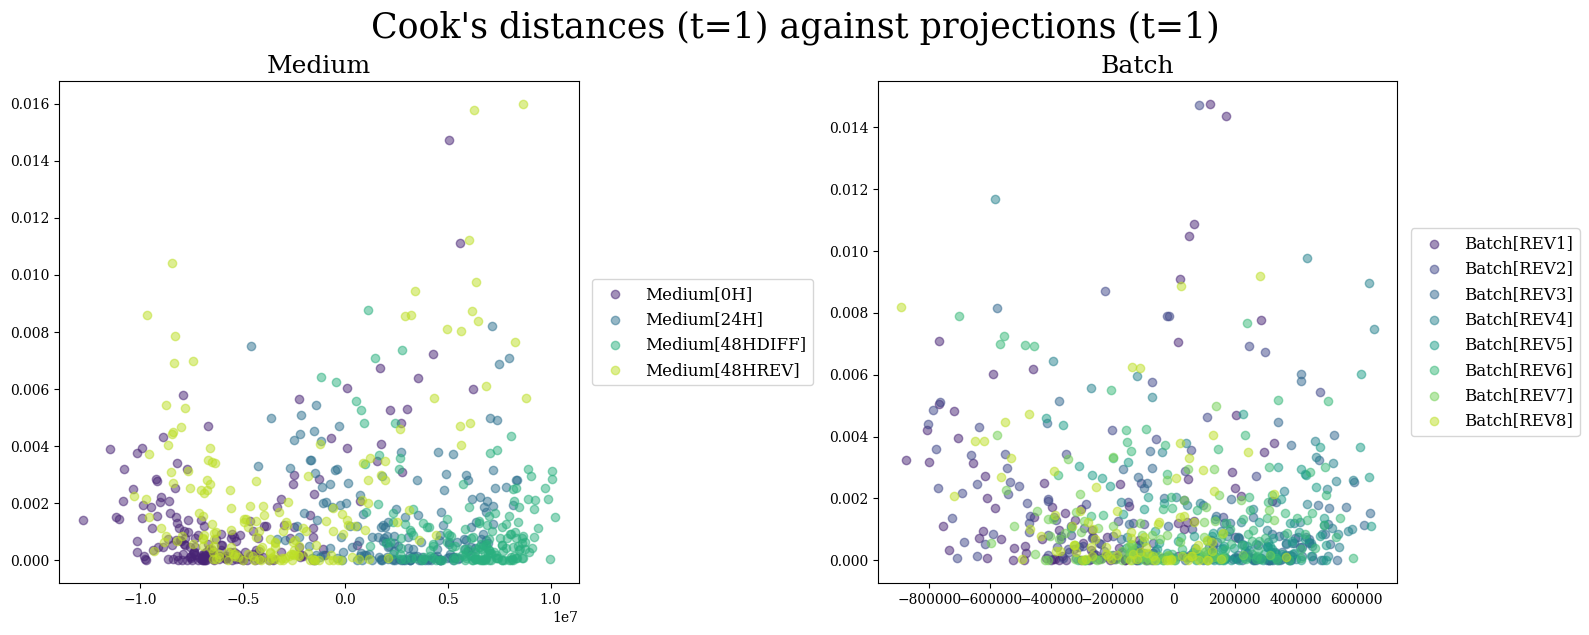

In [38]:
res_1_pw.plot_influence(t1=1, t2=1)

With the by-level tests there are equivalent options as for the projection density plot:

(<Figure size 4800x600 with 6 Axes>,
 array([<Axes: title={'center': 'Medium[0H] = Medium[24H]'}>,
        <Axes: title={'center': 'Medium[0H] = Medium[48HDIFF]'}>,
        <Axes: title={'center': 'Medium[0H] = Medium[48HREV]'}>,
        <Axes: title={'center': 'Medium[24H] = Medium[48HDIFF]'}>,
        <Axes: title={'center': 'Medium[24H] = Medium[48HREV]'}>,
        <Axes: title={'center': 'Medium[48HDIFF] = Medium[48HREV]'}>],
       dtype=object))

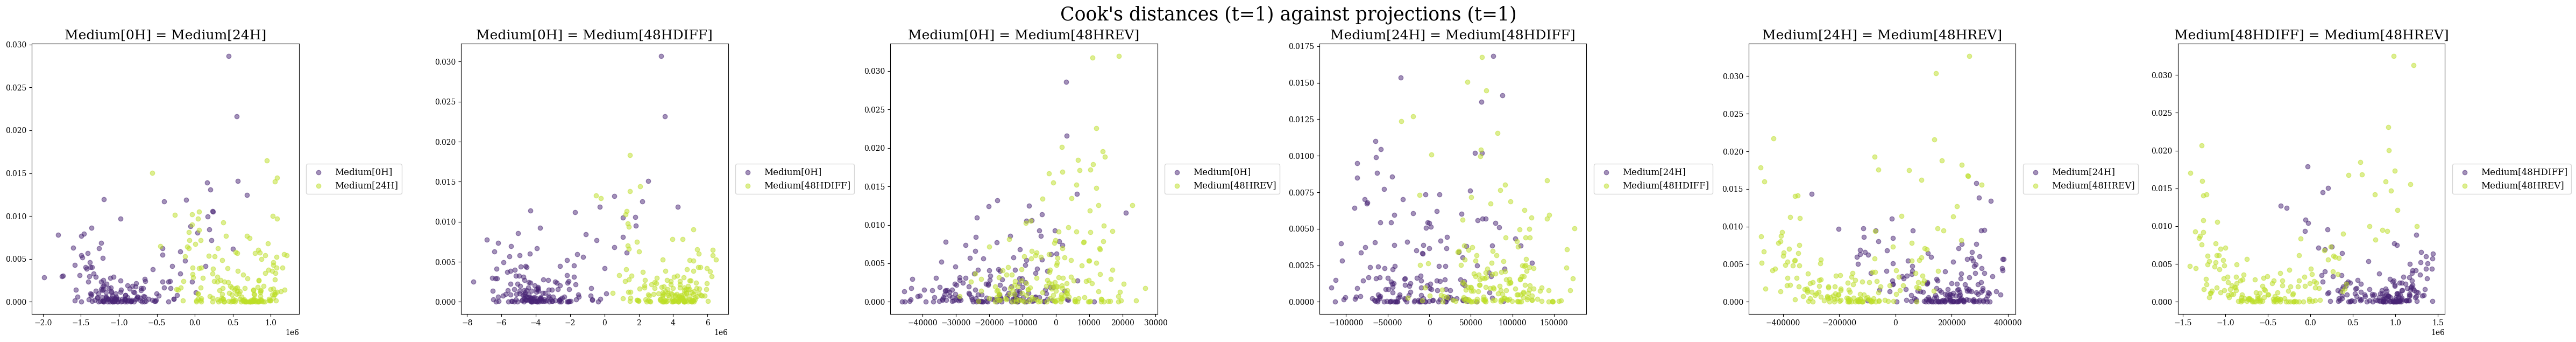

In [39]:
res_1_pw_bl.plot_influence(t1=1, t2=1, tests=[n for n, _ in res_1_pw_bl.hypotheses[:6]])